In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import time
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets
from torchvision import transforms

from sklearn.model_selection import train_test_split
from torch.utils.data import random_split

from PIL import Image

In [2]:
transformer=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5),(0.5))
                                ])

In [3]:
train_data=datasets.CIFAR10(root='./data',train=True,download=True,transform=transformer)
test_data=datasets.CIFAR10(root='./data',train=False,download=True,transform=transformer)

train_loader=DataLoader(train_data,batch_size=64,shuffle=True)
test_loader=DataLoader(test_data,batch_size=100,shuffle=True)

100%|██████████| 170498071/170498071 [00:05<00:00, 33471523.57it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
print(train_data[0][0].shape)
print(test_data[0][0].shape)
print(train_data)
print(test_data)

torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )


In [5]:
# Model 1
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()

    self.conv1 = nn.Conv2d(3,32, kernel_size=3,padding=1)
    self.conv2 = nn.Conv2d(32,64, kernel_size=3,padding=1)
    self.pool=nn.MaxPool2d(2,2)
    self.fc1 = nn.Linear(64*8*8, 128) # Changed the input features to match the output of conv layers
    self.fc2 = nn.Linear(128, 10)

  def forward(self, x):
    x=self.pool(torch.relu(self.conv1(x)))
    x=self.pool(torch.relu(self.conv2(x)))
    x=x.view(-1,64*8*8) # Adjusted the view to match the calculated output size
    x=torch.relu(self.fc1(x))
    x=self.fc2(x)
    return x
model=CNN()

In [6]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [7]:
Loss_fn=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)

In [8]:
#j Frist 7 -> Second -> 8 best 7
for epoch in range(7):
  running_loss=0
  for i,data in enumerate(train_loader,0):
    inputs,labels=data
    optimizer.zero_grad()
    output=model(inputs)   # cpu
    # output=model(inputs.to(device))   # cuda
    loss=Loss_fn(output,labels)  # cpu
    # loss=Loss_fn(output,labels.to(device))   # cuda
    loss.backward()
    optimizer.step()
    running_loss+=loss.item()
    if i % 100 == 99:
      print(f'Train Epoch: {epoch +1} , Batch :{i+1} , Loss: {running_loss/100 :.3f}')
      running_loss=0.0

print('Finished Training')

Train Epoch: 1 , Batch :100 , Loss: 1.881
Train Epoch: 1 , Batch :200 , Loss: 1.534
Train Epoch: 1 , Batch :300 , Loss: 1.374
Train Epoch: 1 , Batch :400 , Loss: 1.348
Train Epoch: 1 , Batch :500 , Loss: 1.228
Train Epoch: 1 , Batch :600 , Loss: 1.186
Train Epoch: 1 , Batch :700 , Loss: 1.162
Train Epoch: 2 , Batch :100 , Loss: 1.044
Train Epoch: 2 , Batch :200 , Loss: 1.039
Train Epoch: 2 , Batch :300 , Loss: 1.005
Train Epoch: 2 , Batch :400 , Loss: 0.965
Train Epoch: 2 , Batch :500 , Loss: 0.956
Train Epoch: 2 , Batch :600 , Loss: 0.957
Train Epoch: 2 , Batch :700 , Loss: 0.917
Train Epoch: 3 , Batch :100 , Loss: 0.842
Train Epoch: 3 , Batch :200 , Loss: 0.821
Train Epoch: 3 , Batch :300 , Loss: 0.861
Train Epoch: 3 , Batch :400 , Loss: 0.836
Train Epoch: 3 , Batch :500 , Loss: 0.828
Train Epoch: 3 , Batch :600 , Loss: 0.832
Train Epoch: 3 , Batch :700 , Loss: 0.786
Train Epoch: 4 , Batch :100 , Loss: 0.731
Train Epoch: 4 , Batch :200 , Loss: 0.725
Train Epoch: 4 , Batch :300 , Loss

In [9]:
correct=0
total=0
with torch.no_grad():
  for data in test_loader:
    images,labels=data
    outputs=model(images)   # cpu
    # images = images.to(device)  # cuda
    # labels = labels.to(device) # cuda
    # outputs=model(images)   # cuda
    _,predicted=torch.max(outputs.data,1)
    total+=labels.size(0)
    correct+=(predicted==labels).sum().item()
    print(f'Accuracy of the network on the 10000 test images: {100*correct/total :.2f}%')

Accuracy of the network on the 10000 test images: 67.00%
Accuracy of the network on the 10000 test images: 71.00%
Accuracy of the network on the 10000 test images: 71.33%
Accuracy of the network on the 10000 test images: 71.50%
Accuracy of the network on the 10000 test images: 72.20%
Accuracy of the network on the 10000 test images: 73.00%
Accuracy of the network on the 10000 test images: 73.00%
Accuracy of the network on the 10000 test images: 73.00%
Accuracy of the network on the 10000 test images: 72.56%
Accuracy of the network on the 10000 test images: 71.60%
Accuracy of the network on the 10000 test images: 71.36%
Accuracy of the network on the 10000 test images: 71.17%
Accuracy of the network on the 10000 test images: 71.00%
Accuracy of the network on the 10000 test images: 71.50%
Accuracy of the network on the 10000 test images: 71.60%
Accuracy of the network on the 10000 test images: 71.69%
Accuracy of the network on the 10000 test images: 71.41%
Accuracy of the network on the 

In [53]:
from google.colab import files
up = files.upload()

Saving Air.jpg to Air.jpg


In [54]:
# This is write Gemini
import io
filename = next(iter(up))
image_bytes = up[filename]
image = Image.open(io.BytesIO(image_bytes))

In [55]:
transformers = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32,32)),
    transforms.Normalize((0.5),(0.5))
])

img = transformers(image)

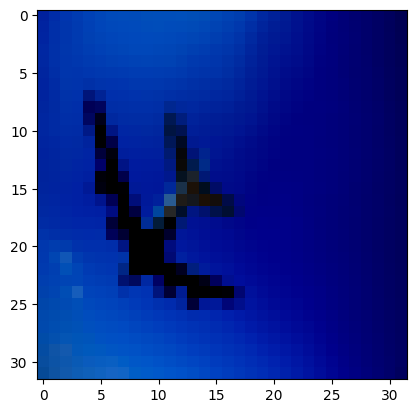

In [56]:
plt.imshow(img.permute(1,2,0)) # I help in gemini because this is error

In [57]:
model.eval()

with torch.no_grad():
    output = model(img)
    _, predicted = torch.max(output.data, 1)
    Show=train_data.classes[predicted]

    print(Show)
    print(predicted)

airplane
tensor([0])


In [52]:
# I don't think correct
# Why don't write test_data
train_data.classes[predicted]

'automobile'